<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>
<hr/>
<font color="#800080" size=5>
Assignment 1 : Deep Autoregressive Models
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: Month day at 23:55
</font>
<hr>
<font color='red'  size=4>
Note: It is highly recommended to run your notebook on Google Colab or Kaggle
<br>
</font>
<font face="Times New Roman" size=4 align=center>
Feel free to ask your questions in Telegram : @ilia_ad7
</font>
<br>
<hr>
</div></font>

In [ ]:
Name = "fariborz kohanzad"
StudentId = "400103613"

# Introduction

Deep autoregressive models are sequence models, yet feed-forward (i.e. not recurrent); generative models, yet supervised. They are a compelling alternative to RNNs for sequential data, and GANs for generation tasks.

Moreover, a deep autoregressive model is merely a feed-forward model which predicts future values from past values.

However, you may think that the term **Autoregressive** is equivalent to **Deep Autoregressive**; But actually, it is not true! Autoregressive Linear Models like `ARMA` or `ARCH` have been used in statistics, econometrics and financial modelling for ages and are not **Deep**. In this exercise, we work with deep ones.

### Mathematical Description
The mathematical foundation of autoregressive models is based on the chain rule of probability. We can factorize the joint distribution over the n-dimensions as:

$$p(x) = \prod_{i=1}^{n} p(x_i | x_1, x_2, …, x_{i-1}) = \prod_{i=1}^{n} p(x_i | x_{<i})$$

where $x_{<i} = [x_1, x_2, …, x_{i-1}]$ denotes the vector of random variables with index less than $i$.

### Advantages and Disadvantages
Autoregressive models are naturally strong generative models that constitute one of the current state-of-the-art architectures on likelihood-based image modeling, and are also the basis for large language generation models such as GPT3. Similar to the language generation, autoregressive models work on images by modeling the likelihood of a pixel given all previous ones. For instance, in the picture below, we model the pixel $x_i$ as a conditional probability distribution based on all previous (here blue) pixels (figure credit - [Aaron van den Oord et al.](https://arxiv.org/abs/1601.06759)):

<center style="padding: 10px"><img src="AR_ImageProcessing.svg" height="300px"></center>

Learning these conditionals is often much simpler than learning the joint distribution $p(\mathbf{x})$ all together. However, disadvantages of autoregressive models include slow sampling, especially for large images, as we need height-times-width forward passes through the model. In addition, for some applications, we require a latent space as modeled in VAEs and Normalizing Flows. For instance, in autoregressive models, we cannot interpolate between two images because of the lack of a latent representation.

### Some Architectures and Applications of Autoregressive Models

- `PixelCNN` by Google DeepMind was probably the first deep autoregressive model, and the progenitor of most of the other models below. Ironically, the authors spend the bulk of the paper discussing a recurrent model, PixelRNN, and consider PixelCNN as a “workaround” to avoid excessive computation. However, PixelCNN is probably this paper’s most lasting contribution.
- `PixelCNN++` by OpenAI is, unsurprisingly, PixelCNN but with various improvements.
- `WaveNet` by Google DeepMind is heavily inspired by PixelCNN, and models raw audio, not just encoded music. They had to pull a neat trick from telecommunications/signals processing in order to cope with the sheer size of audio (high-quality audio involves at least 16-bit precision samples, which means a 65,536-way-softmax per time step!)
- `Transformer`, a.k.a. the “attention is all you need” model by Google Brain is now a mainstay of NLP, performing very well at many NLP tasks and being incorporated into subsequent models like BERT.

# Install Pre-requirements

In [2]:
!pip install -q yfinance
!pip install --quiet pytorch-lightning>=1.4

# Question 1 : LSTM

### **The Model**
In this exercise, we will explore the application of Long Short-Term Memory (LSTM) networks, a type of recurrent neural network, to predict stock prices. LSTMs are particularly suited for this task due to their ability to capture long-term dependencies in time series data.

We will treat this as an autoregressive problem, where we use past stock prices to predict future ones. Autoregressive models are widely used in time series forecasting, and they can capture complex patterns in the data.

The goal of this exercise is to familiarize you with the process of training an LSTM network and using it for prediction. You will learn how to preprocess time series data, visualize it, construct an LSTM model, train it on historical stock price data, and evaluate its performance.

Remember, predicting stock prices is a complex task and the aim of this exercise is not to create a model for making actual investment decisions, but rather to understand the potential applications of LSTM networks in time series forecasting.

### **The Dataset**
The initial phase of our process involves the acquisition and loading of requisite data into memory. Our primary data source will be Yahoo Finance, a comprehensive platform renowned for its extensive repository of financial market data and its suite of tools designed to identify promising investment opportunities. To facilitate the extraction of data from Yahoo Finance, we will employ the yfinance library, which provides a Pythonic and multi-threaded approach to downloading market data.

## Load the Data

The process begins with data acquisition from Yahoo Finance and loading it into memory. Yahoo Finance is utilized for its extensive financial market data. The yfinance library, known for its efficient and Python-friendly approach, is used to download this data.

In [3]:
# Import necessary libraries here. You may add other libraries to suit your needs.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas_datareader as pdr
from pandas_datareader.data import DataReader
import yfinance as yf
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable
import random
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset


def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

set_seed(47)

# Set up plot style
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

yf

# Define the list of tech stocks for analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up the start and end times for data grab
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

# Download stock data and assign it to global variables
for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)

# Define the list of companies and their names
company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

# Add company name to each dataframe
for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

# Concatenate all company dataframes
df = pd.concat(company_list, axis=0)

# Display the last 10 rows of the dataframe
df.tail(10)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2024-10-07,182.949997,183.600006,180.250000,180.800003,180.800003,42364200,AMAZON
2024-10-08,181.919998,183.089996,180.919998,182.720001,182.720001,26372100,AMAZON
2024-10-09,182.820007,185.850006,182.050003,185.169998,185.169998,26343100,AMAZON
2024-10-10,187.130005,188.130005,185.830002,186.649994,186.649994,27785000,AMAZON
2024-10-11,186.630005,189.929993,186.300003,188.820007,188.820007,25751600,AMAZON
2024-10-14,189.779999,189.830002,187.360001,187.539993,187.539993,22614400,AMAZON
2024-10-15,187.630005,188.410004,184.580002,187.690002,187.690002,32178900,AMAZON
2024-10-16,187.050003,187.779999,185.610001,186.889999,186.889999,23456800,AMAZON
2024-10-17,188.220001,188.940002,186.000000,187.529999,187.529999,25039400,AMAZON


## Statistical Analysis

The `.describe()` function generates descriptive statistics that summarize the central tendency, dispersion, and shape of a dataset's distribution, excluding `NaN` values. It can analyze both numeric and object series, as well as DataFrame column sets of mixed data types. The output varies based on the input data.

Use this function to generate a concise statistical summary of one of the stocks.

In [4]:
##### Step 1: Statistical summary #####
AAPL.describe()

,Open,High,Low,Close,Adj Close,Volume
count,250.000000,250.000000,250.000000,250.000000,250.000000,2.500000e+02
mean,197.114600,198.891480,195.423520,197.276360,196.879497,5.876267e+07
std,21.002997,21.209843,20.586321,20.949592,21.141499,3.020008e+07
min,165.350006,166.399994,164.080002,165.000000,164.585999,2.404830e+07
25%,182.015003,183.075005,180.330002,182.010002,181.310902,4.350712e+07
50%,191.250000,192.410004,189.895004,191.379997,190.827484,5.228615e+07
75%,218.989994,221.427498,216.724998,219.595001,219.341114,6.529722e+07
max,236.479996,237.490005,234.009995,235.000000,235.000000,3.186799e+08


Now, using the `.info()` method, provide a concise summary of the DataFrame. This includes information such as:
1. The number of entries (rows)
2. The number of columns
3. The names of the columns
4. The number of non-null values in each column
5. The data type of each column (e.g., integer, float, object)

In [5]:
##### Step 2: DataFrame summary #####
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2023-10-23 to 2024-10-18
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1000 non-null   float64
 1   High          1000 non-null   float64
 2   Low           1000 non-null   float64
 3   Close         1000 non-null   float64
 4   Adj Close     1000 non-null   float64
 5   Volume        1000 non-null   int64  
 6   company_name  1000 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 62.5+ KB


The closing price, the last traded price during a regular trading day, is a key benchmark for tracking stock performance.
Let's visualize the historical closing prices for our list of companies.

Text(0.5, 1.0, 'Historical Closing Prices')

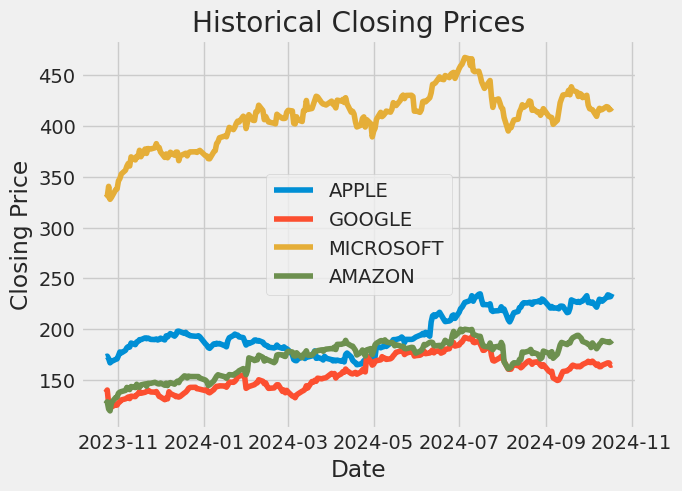

In [6]:
##### Step 3: Visualize the historical closing prices #####
x = list(df.index[df['company_name'] == 'APPLE'].values)
y1 = df.loc[df['company_name'] == 'APPLE']['Close']
y2 = df.loc[df['company_name'] == 'GOOGLE']['Close']
y3 = df.loc[df['company_name'] == 'MICROSOFT']['Close']
y4 = df.loc[df['company_name'] == 'AMAZON']['Close']

plt.plot(x, y1, label='APPLE')
plt.plot(x, y2, label='GOOGLE')
plt.plot(x, y3, label='MICROSOFT')
plt.plot(x, y4, label='AMAZON')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Historical Closing Prices')

Volume refers to the number of shares traded during a certain period, often a day. It's a key metric for technical traders.
Let's visualize the daily trading volume for our list of companies.

Text(0.5, 1.0, 'Historical Volumes')

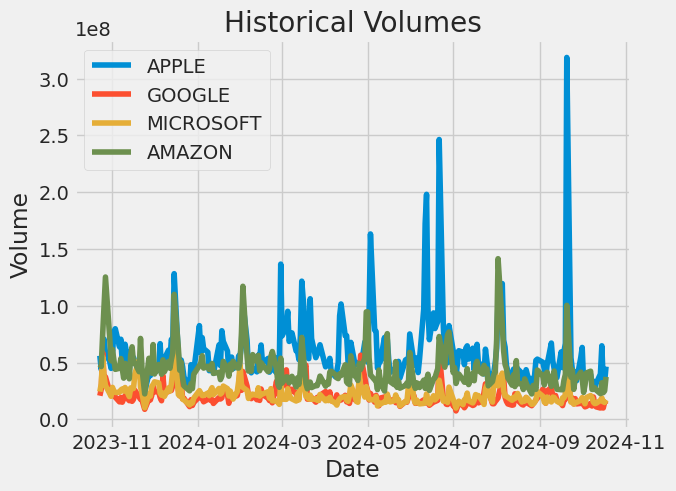

In [7]:
##### Step 4: Visualize the daily trading volume #####
z1 = df.loc[df['company_name'] == 'APPLE']['Volume']
z2 = df.loc[df['company_name'] == 'GOOGLE']['Volume']
z3 = df.loc[df['company_name'] == 'MICROSOFT']['Volume']
z4 = df.loc[df['company_name'] == 'AMAZON']['Volume']

plt.plot(x, z1, label='APPLE')
plt.plot(x, z2, label='GOOGLE')
plt.plot(x, z3, label='MICROSOFT')
plt.plot(x, z4, label='AMAZON')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Historical Volumes')

A stock moving average (MA) is a widely used technical indicator in financial analysis that helps smooth out price trends by filtering out the noise from random short-term price fluctuations. It is calculated by taking the arithmetic mean of a given set of prices over a specified period.

The moving average can be of different types, such as Simple Moving Average (SMA) and Exponential Moving Average (EMA). SMA is calculated by taking the arithmetic mean of a given set of prices over a specified period. On the other hand, EMA places greater weight on more recent prices than older ones over the time period.

Here, you should calculate and plot the 10, 20, and 50-day moving averages along with the adjusted close price for each company. The moving averages are calculated using the `rolling` method, which applies a function (in this case, mean) to a rolling window of data. The plots provide a visual representation of the stock price trends over time.

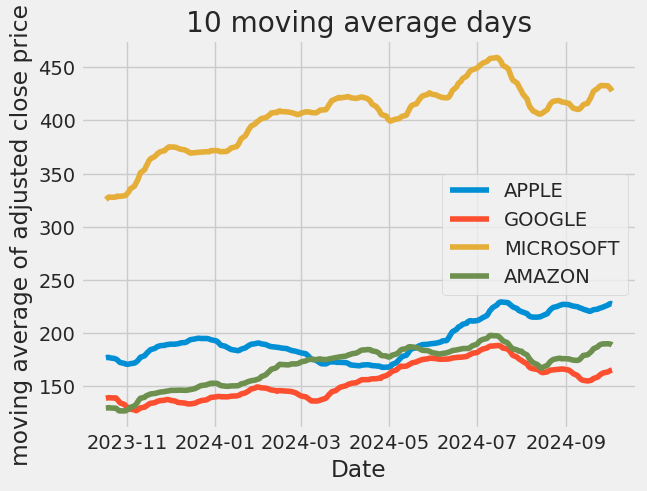

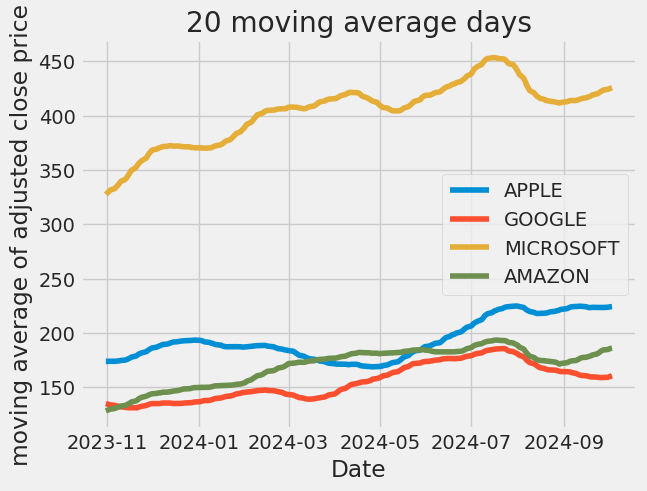

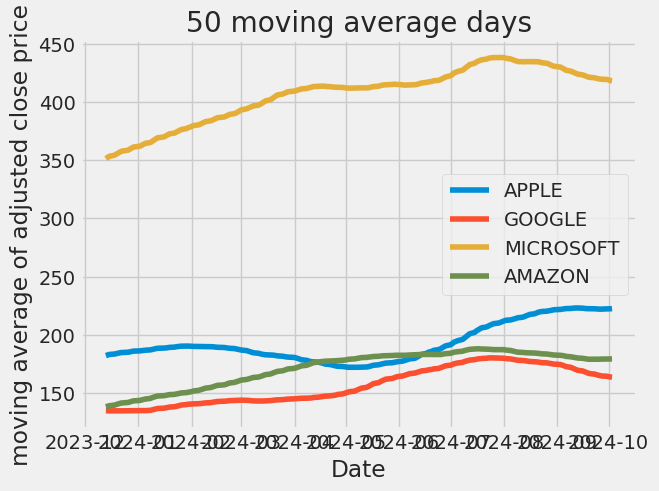

In [ ]:
ma_day = [10, 20, 50]

mov_avg = []
for ma in ma_day:
  for com_name in company_name:
    mov_avg.append(df[df['company_name'] == com_name]['Adj Close'].rolling(ma).mean()) # Use append to add the calculated moving average to the list

for i in range(3):
  x= list(df.index[df['company_name'] == 'APPLE'].values)
  plt.figure(i)
  plt.plot(x, mov_avg[4*i], label='APPLE')
  plt.plot(x, mov_avg[4*i + 1], label='GOOGLE')
  plt.plot(x, mov_avg[4*i + 2], label='MICROSOFT')
  plt.plot(x, mov_avg[4*i + 3], label='AMAZON')
  plt.legend()
  plt.xlabel('Date')
  plt.ylabel('moving average of adjusted close price')
  plt.title(f'{ma_day[i]} moving average days')

Now answer this **Question:**

Which moving average is the best choice for predicting the trends? Justify your answer.

Explain your **Answer:**

The 20 day moving average is the best option. since it balances smoothness with visual indication of data trends. Thw 10 day moving average has fluctuations still and the 50 day moving average is too smooth, to the point of data elimination.

Now that we've done some baseline analysis, let's go ahead and dive a little deeper. We're now going to analyze the risk of the stock. In order to do so we'll need to take a closer look at the daily changes of the stock, and not just its absolute value. Let's go ahead and use pandas to retrieve daily returns for all stocks. We'll use `pct_change` to find the percent change for each day.

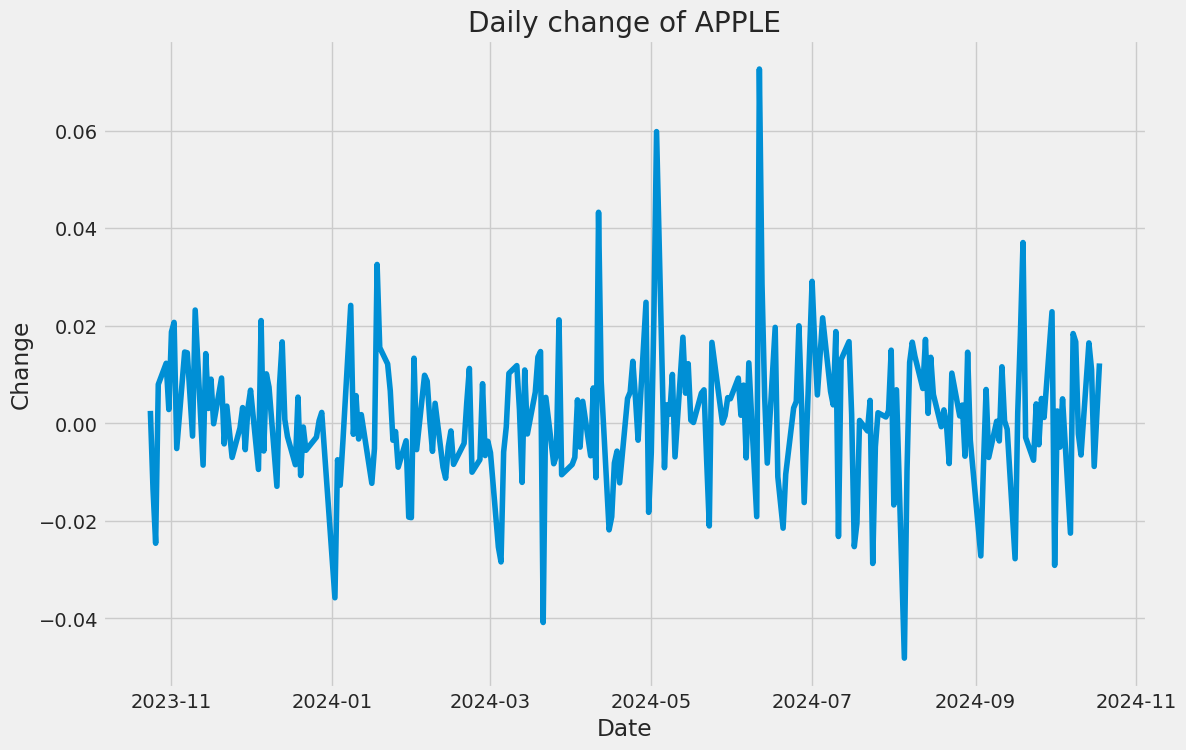

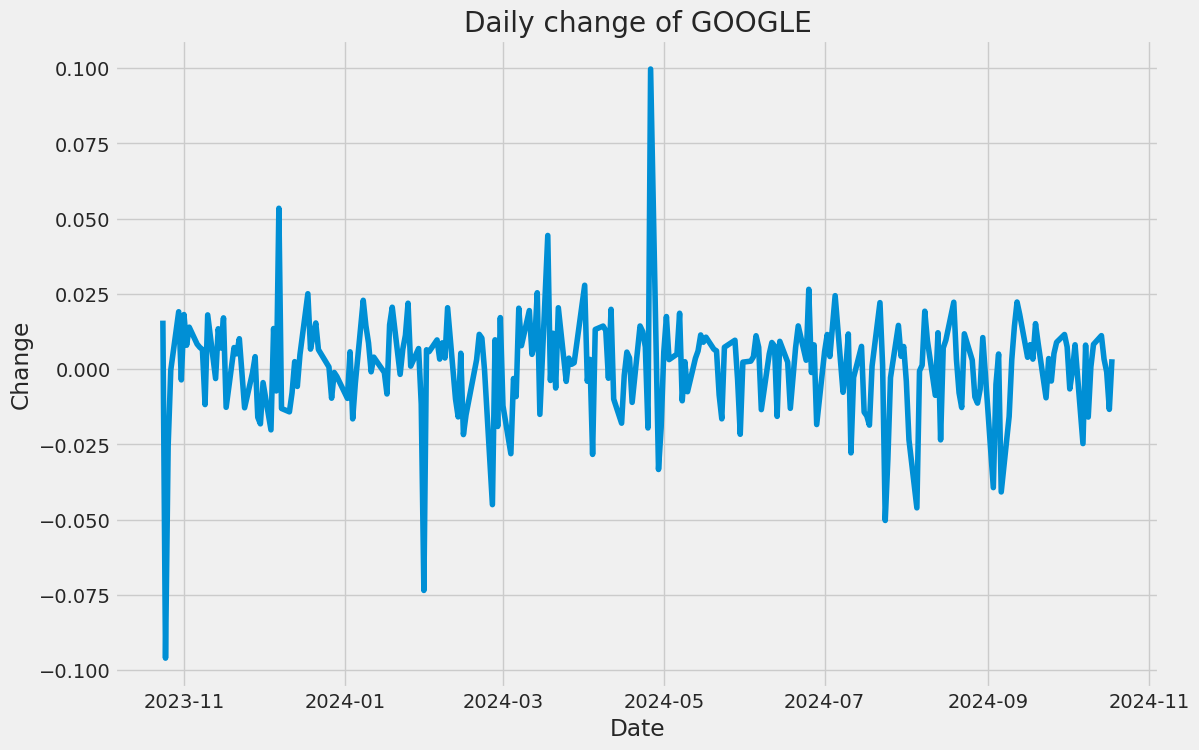

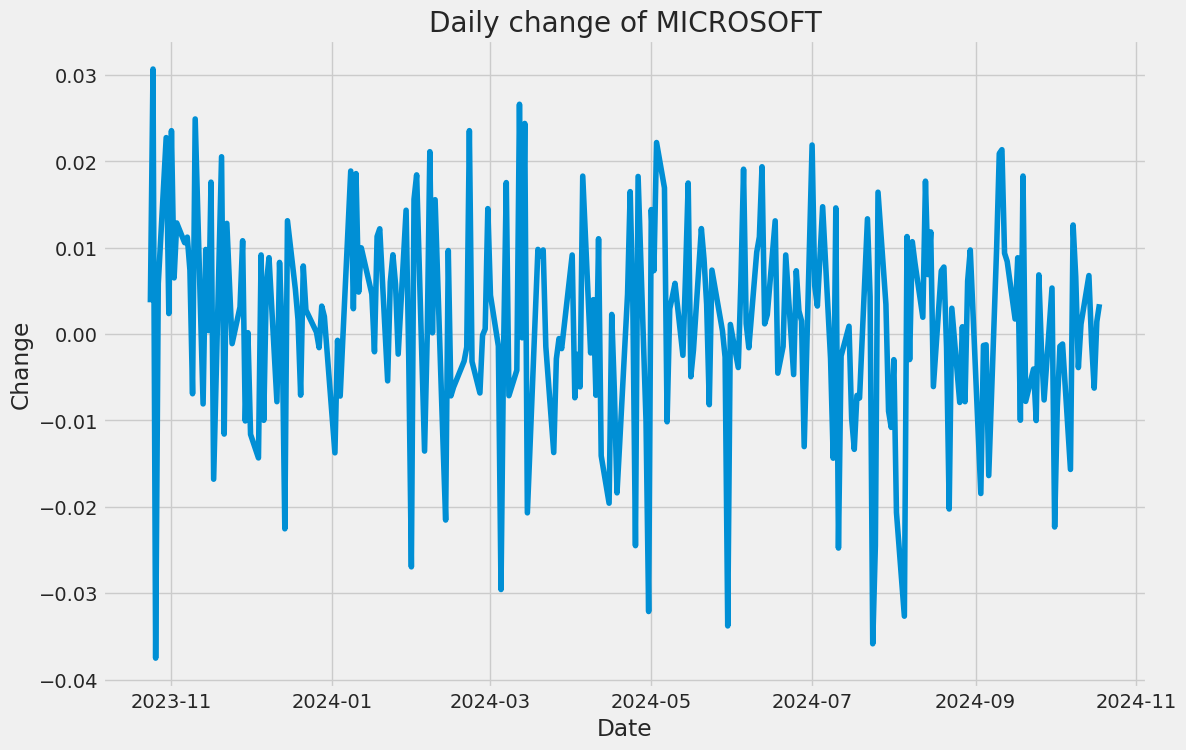

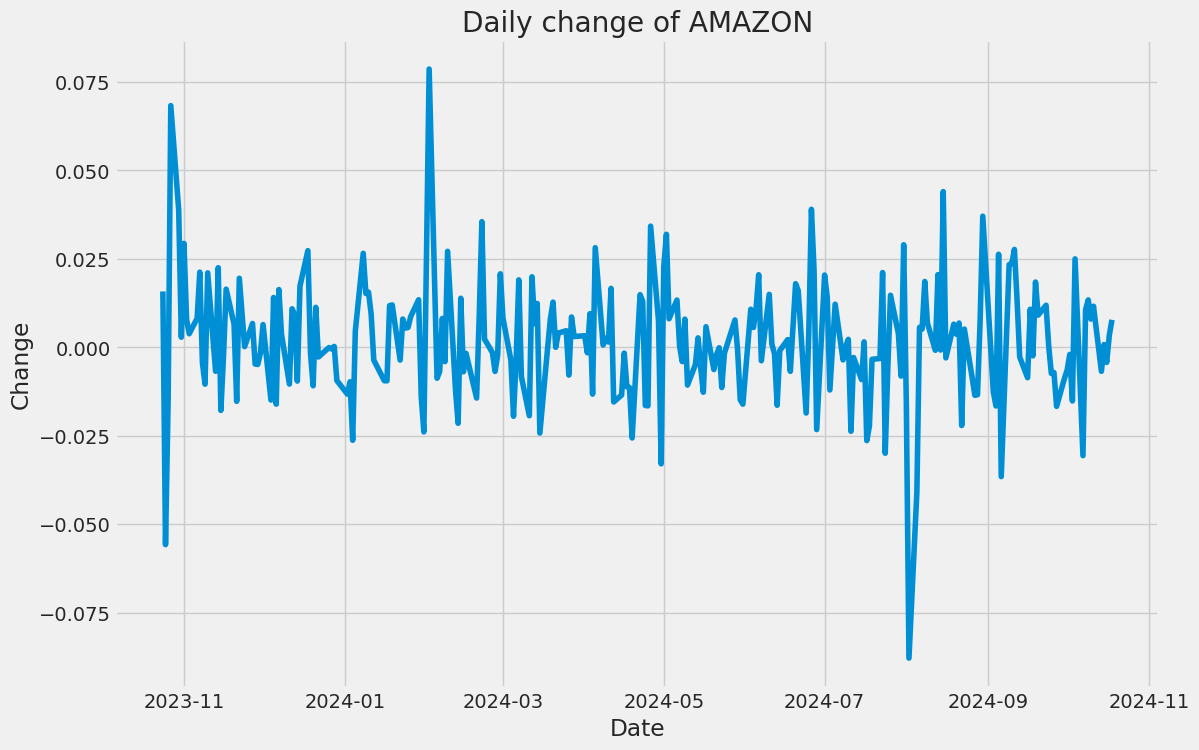

In [9]:
##### Step 6: Plot the daily return precentages #####
daily_change = []
for com_name in company_name:
  daily_change.append(df[df['company_name'] == com_name]['Adj Close'].pct_change() )

for i in range(4):
  plt.figure(i,(12,8))
  plt.plot(x, daily_change[i])
  plt.xlabel('Date')
  plt.ylabel('Change')
  plt.title(f'Daily change of {company_name[i]}')

Now let's get an overall look at the daily returns by creating a histogram for the `Daily Return` of each company in the `company_list`.

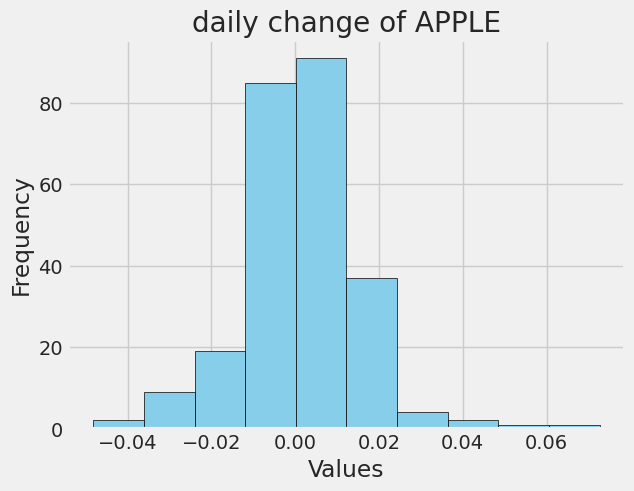

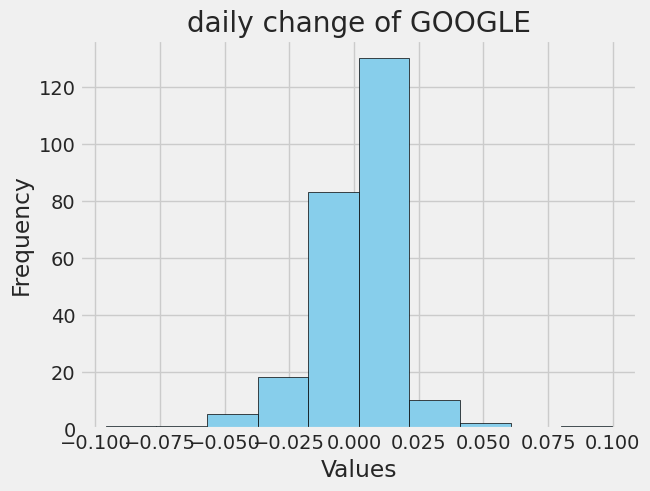

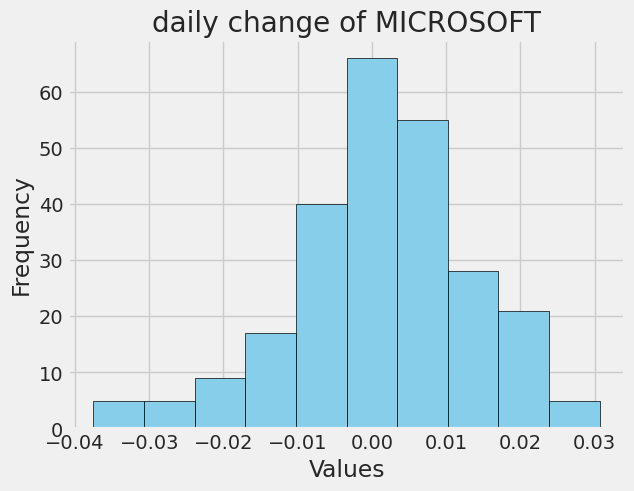

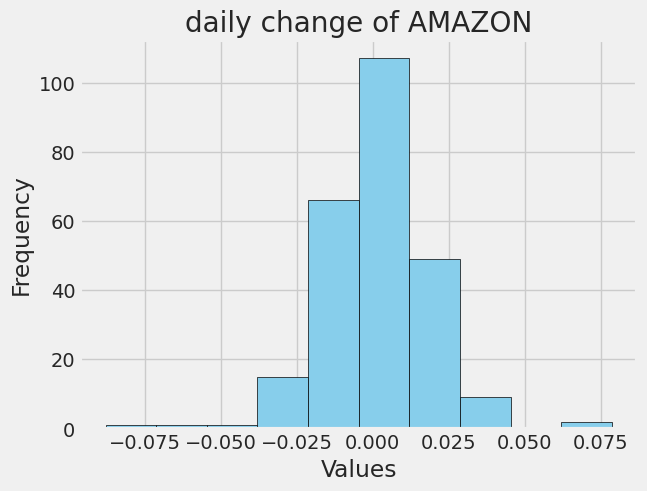

In [ ]:
##### Step 7: Plot the histogram of Daily Returns #####
for i in range(4):
  plt.figure(i)
  plt.hist(daily_change[i], color='skyblue', edgecolor='black')
  plt.xlabel('Values')
  plt.ylabel('Frequency')
  plt.title(f'daily change of {company_name[i]}')


## Correlation between Different Stocks Closing Prices

Correlation is a statistical measure that quantifies the degree of relationship between two variables. It provides an indication of how changes in one variable are associated with changes in another. The correlation coefficient ranges between -1.0 and +1.0. A correlation of +1.0 indicates a perfect positive correlation, meaning that both variables move in the same direction together. A correlation of -1.0 indicates a perfect negative correlation, meaning that the variables move in opposite directions. If the correlation is 0, it means there is no relationship between the variables. However, it's important to note that correlation does not imply causation. Even if two variables are correlated, it does not mean that changes in one variable are causing changes in another. There could be a third factor influencing both variables.

In the context of stock analysis, suppose we are interested in examining the returns of all the stocks in our list. To facilitate this, we can construct a DataFrame that consolidates the `Adj Close` columns from each of the individual stock dataframes. This will provide us with a comprehensive view of the closing prices for all stocks, enabling more efficient comparative analysis.

In [10]:
# Get the closing prices for all stocks in the tech list
data = yf.download(tech_list, start=start, end=end)

# Select only the 'Adj Close' column for each stock
closing_df = data['Adj Close']

# Calculate the daily returns for each stock
tech_rets = closing_df.pct_change()

# Display the first few rows of the returns DataFrame
tech_rets.head()

[*********************100%***********************]  4 of 4 completed


Ticker,AAPL,AMZN,GOOG,MSFT
Date,,,,
2023-10-23 00:00:00+00:00,NaN,NaN,NaN,NaN
2023-10-24 00:00:00+00:00,0.002543,0.015803,0.016099,0.003674
2023-10-25 00:00:00+00:00,-0.013492,-0.055772,-0.095989,0.030678
2023-10-26 00:00:00+00:00,-0.024606,-0.014993,-0.025499,-0.037514
2023-10-27 00:00:00+00:00,0.007969,0.068328,-0.000324,0.005856


Now we can compare the daily percentage return of all pairs to check how they are correlated.

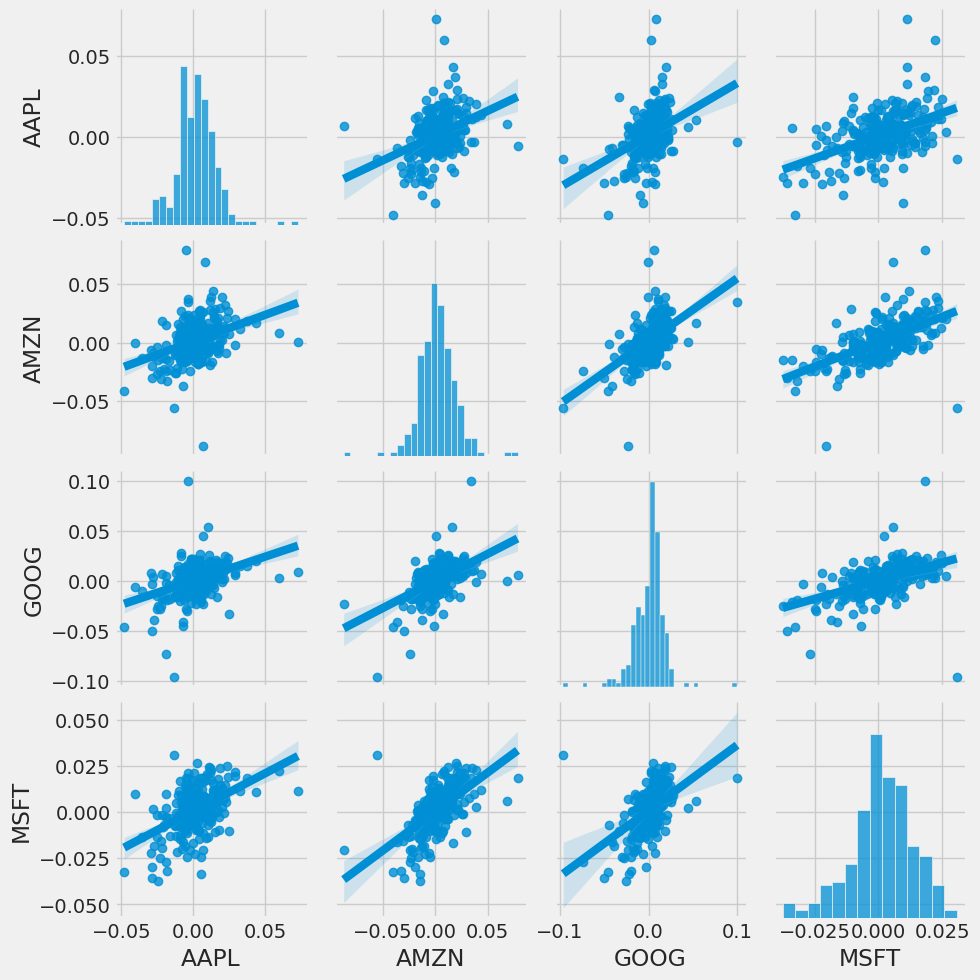

In [11]:
sns.pairplot(tech_rets.dropna(), kind='reg')

Now, answer this **Question:**

What implications might a linear relationship have for investment strategies?

Explain your **Answer:**

The implication is that one can decide to whether or not invest in a particular stock if the prices of a correlated stock has been on the rise.

Finally, Let's create two heatmaps: one for the correlation between the daily returns of the stocks and another for the correlation between the closing prices of the stocks. This provides a visual and numerical understanding of the relationships between different stocks.

Text(0.5, 1.0, 'Closing price correlation heatmap')

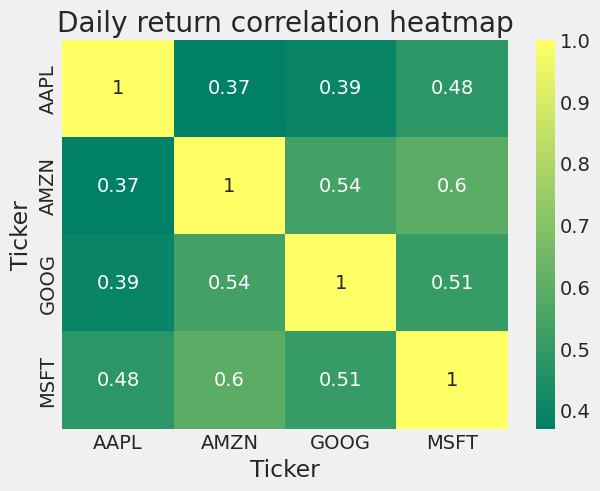

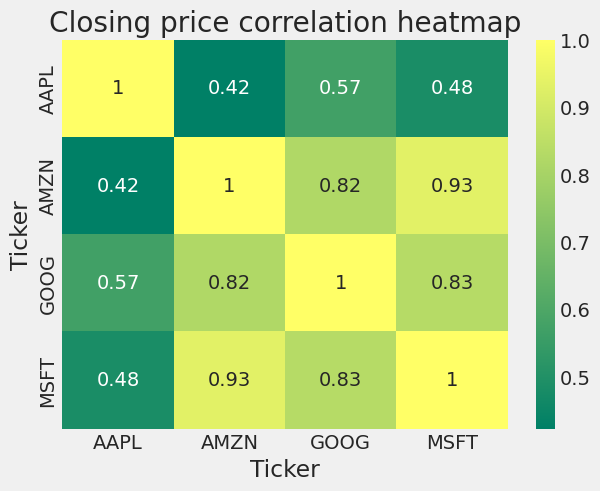

In [12]:
#Ploting daily return heatmap
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')
plt.title('Daily return correlation heatmap')

# ploting closing data correlation heatmap
close_df = data['Close']
plt.figure()
sns.heatmap(close_df.corr(), annot=True, cmap='summer')
plt.title('Closing price correlation heatmap')



Now, answer this **Question:**

Which pair has the strongest correlation of daily return stocks? What other interesting facts could be infered from the plots above?

Explain your **Answer:**

It seems that Microspft and Google have the stringest correaltion. It also seems that there is strong correaltion between the closing orices of Goolge, Amazon and Microsoft.

## Predicting the Closing Price

In this section, we will try to predict the closing price of a stock using an LSTM model. Choose one stock and after visualizing the closing history, do any preprocessing you need and create a training data set.

In [13]:
stock = yf.download('AAPL', start='2012-01-01')
stock.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.402628,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.469276,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.607713,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.739511,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.719307,394024400


Text(0, 0.5, 'Closing price')

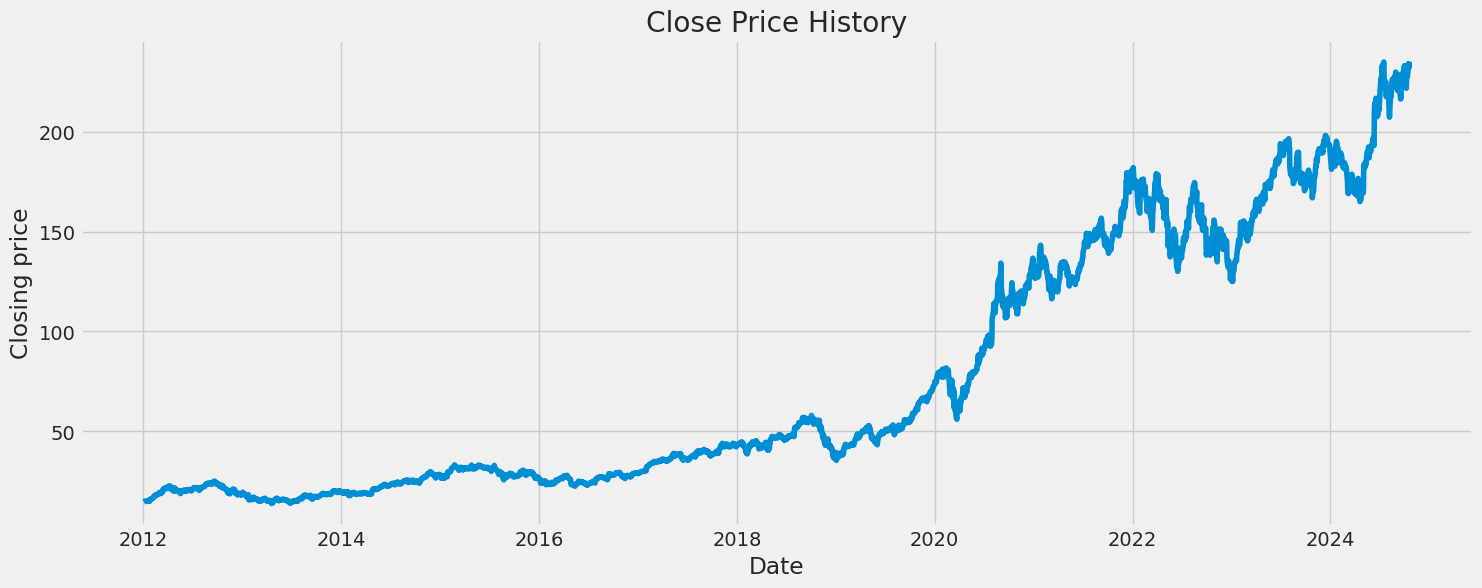

In [18]:
plt.figure(figsize=(16,6))
plt.plot(stock['Close'])
plt.title("Close Price History")
plt.xlabel("Date")
plt.ylabel("Closing price")

In [19]:
# Loading the data
data = stock['Close']
train_size = int(len(data) * 0.95)
train_data, test_data = data[:train_size], data[train_size:]

train_data = train_data.values.reshape(-1, 1)
test_data = test_data.values.reshape(-1, 1)

In [20]:
#Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

In [26]:
# Creating the training and test data sets
def create_sequences(data, time_steps):
    x, y = [], []
    for i in range(len(data) - time_steps):
        x.append(data[i:i + time_steps, 0])
        y.append(data[i + time_steps, 0])
    return np.array(x), np.array(y)

x_train, y_train = create_sequences(train_data_scaled, time_steps = 10)
x_test, y_test = create_sequences(test_data_scaled, time_steps = 10)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

Now, define your model here

In [50]:
# LSTM Model

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_layers, output_size):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size1, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size1, hidden_size2)
        self.fc2 = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()


    def forward(self, x):
        x , _= self.lstm(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        x = self.relu(x)
        out = self.fc2(x)
        return out

# Hyperparameters
num_epochs = 40
learning_rate = 1e-3
batch_size = 32
input_size = 1
hidden_size1 = 50
hidden_size2 = 20
num_layers = 2
seq_length = 10
output_size = 1

lstm = LSTM(input_size, hidden_size1, hidden_size2, num_layers, output_size)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [51]:
# training the model
def train_model(model,X_train, y_train, X_test, y_test, num_epochs=num_epochs, batch_size = batch_size):

    X_train_tensor = torch.Tensor(X_train)
    y_train_tensor = torch.Tensor(y_train).view(-1, 1)
    X_test_tensor = torch.Tensor(X_test)
    y_test_tensor = torch.Tensor(y_test).view(-1, 1)


    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, (batch_X, batch_y) in enumerate(train_loader):

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

train_model(lstm, x_train, y_train, x_test, y_test)

Epoch [10/40], Loss: 0.0004
Epoch [20/40], Loss: 0.0002
Epoch [30/40], Loss: 0.0004
Epoch [40/40], Loss: 0.0002


In [52]:
# Model evaluation
def evaluate_model(model,X_train, y_train, X_test, y_test):
    X_train_tensor = torch.Tensor(X_train)
    y_train_tensor = torch.Tensor(y_train).view(-1, 1)
    X_test_tensor = torch.Tensor(X_test)
    y_test_tensor = torch.Tensor(y_test).view(-1, 1)

    model.eval()
    with torch.no_grad():
        predicted_train = model(X_train_tensor).detach().numpy()
        predicted_test = model(X_test_tensor).detach().numpy()


        test_loss = criterion(torch.Tensor(predicted_test), y_test_tensor).item()
        print(f'Test MSE Loss: {test_loss:.4f}')

    return predicted_train, predicted_test

predicted_train, predicted_test = evaluate_model(lstm, x_train, y_train, x_test, y_test)

Test MSE Loss: 0.0005


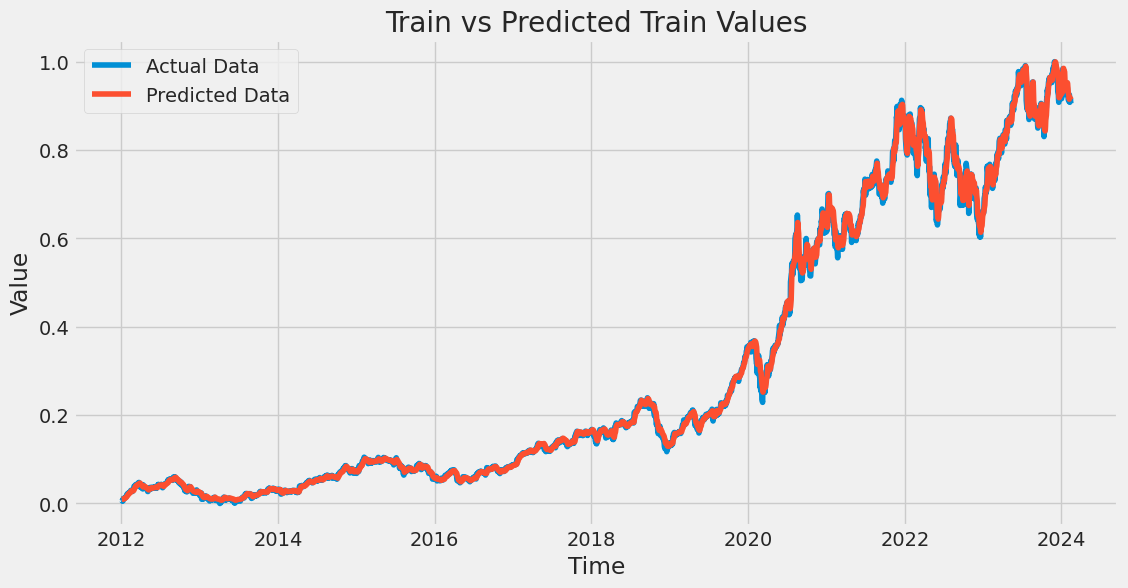

In [74]:
# Plot trai data and predicted data
def plot_predictions(y_test, predicted_test, title , is_train):
    plt.figure(figsize=(12, 6))
    if is_train:
       x= list(data.index.values)[:len(y_test)]
    else:
       x = list(data.index.values)[-len(y_test):]

    plt.plot(x,y_test, label='Actual Data')
    plt.plot(x,predicted_test, label='Predicted Data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

plot_predictions(y_train, predicted_train, title="Train vs Predicted Train Values" , is_train= True)

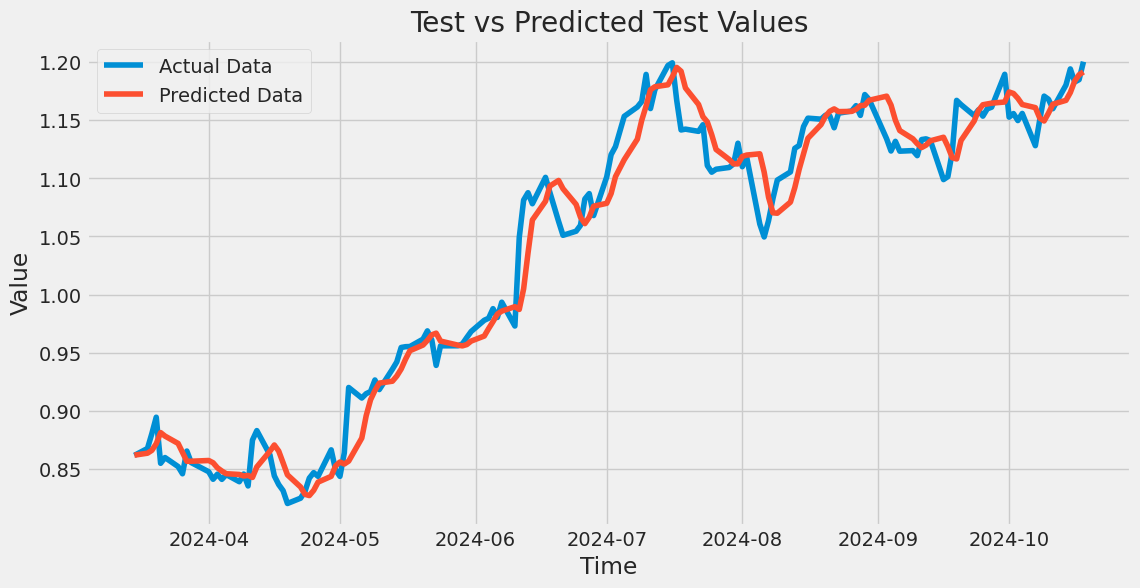

In [75]:
# Plot test data and predicted data
plot_predictions(y_test, predicted_test, title="Test vs Predicted Test Values" , is_train=False)

## Optional
You have the opportunity to develop an autoregressive model based on the concepts you learned in class and subsequently train it. Following that, you can compare its performance with that of the LSTM model

In [ ]:
#### Bonus ####


# Question 2 : PixelCNN

In this question, we implement an autoregressive likelihood model for the task of image modeling. Our implementation will focus on the PixelCNN [2] model. Most current SOTA models use PixelCNN as their fundamental architecture, and various additions have been proposed to improve the performance (e.g. PixelCNN++ and PixelSNAIL).


## Import Libraries and Requirements
First of all, we need to import our standard libraries. We will use PyTorch Lightning here for the training process.

In [76]:
## Standard libraries
import os
import math
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import seaborn as sns

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

<ipython-input-76-0a1c2b778d6b>:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device cpu


<Figure size 640x480 with 0 Axes>

The next cell is for the further usages. Just run it!

In [77]:
# Create checkpoint path if it doesn't exist yet
os.makedirs('../saved_model', exist_ok=True)

## Load the Data
We will work on the MNIST dataset and use 8-bits per pixel (values between 0 and 255). The dataset is loaded below:

In [78]:
# Convert images from 0-1 to 0-255 (integers). We use the long datatype as we will use the images as labels as well
def discretize(sample):
    return (sample * 255).to(torch.long)

# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor(),
                                discretize])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 57343198.51it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 1707483.28it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 7176558.35it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 3919055.50it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw




INFO:lightning_fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


A good practice is to always visualize some data examples to get an intuition of the data. You should complete the following function to do so:

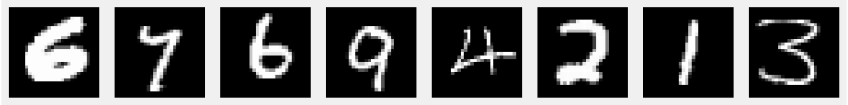

In [82]:
def show_imgs(imgs):
    """
    Function to display images in a grid.
    TODO: Implement the function that displays 'imgs' in a grid.

    Args:
    - imgs: a batch of images in tensor format or a list of images

    You can use matplotlib or other libraries to visualize the images.
    """
    fig, axes = plt.subplots(1, len(imgs), figsize=(12,12))

    axes = axes.flatten()

    for _, (img, ax) in enumerate(zip(imgs, axes)):
        img = img.squeeze(0)

        ax.imshow(img, cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


show_imgs([train_set[i][0] for i in range(8)])


## Masked Autoregressive Convolutions

The core module of PixelCNN is its masked convolutions. In contrast to language models, we don't apply an LSTM on each pixel one-by-one. This would be inefficient because images are grids instead of sequences. Thus, it is better to rely on convolutions that have shown great success in deep CNN classification models.

Nevertheless, we cannot just apply standard convolutions without any changes. Remember that during training of autoregressive models, we want to use teacher forcing which both helps the model training, and significantly reduces the time needed for training. For image modeling, teacher forcing is implemented by using a training image as input to the model, and we want to obtain as output the prediction for each pixel based on only its predecessors. Thus, we need to ensure that the prediction for a specific pixel can only be influenced by its predecessors and not by its own value or any "future" pixels. For this, we apply convolutions with a mask.

Which mask we use depends on the ordering of pixels we decide on, i.e. which is the first pixel we predict, which is the second one, etc. The most commonly used ordering is to denote the upper left pixel as the start pixel, and sort the pixels row by row, as shown in the visualization at the top of the assignment. Thus, the second pixel is on the right of the first one (first row, second column), and once we reach the end of the row, we start in the second row, first column. If we now want to apply this to our convolutions, we need to ensure that the prediction of pixel 1 is not influenced by its own "true" input, and all pixels on its right and in any lower row. In convolutions, this means that we want to set those entries of the weight matrix to zero that take pixels on the right and below into account. As an example for a $5\times 5$ kernel, see a mask below (figure credit - Aaron van den Oord):

<center style=\"padding: 10px\"><img src="Masked_Conv.svg" width="200px"></center>

Before looking into the application of masked convolutions in PixelCNN in detail, let's first implement a module that allows us to apply an arbitrary mask to a convolution:

In [83]:
class MaskedConvolution(nn.Module):

    def __init__(self, c_in, c_out, mask, **kwargs):
        """
        Implements a convolution with mask applied on its weights.
        Inputs:
            c_in - Number of input channels
            c_out - Number of output channels
            mask - Tensor of shape [kernel_size_H, kernel_size_W] with 0s where
                   the convolution should be masked, and 1s otherwise.
            kwargs - Additional arguments for the convolution
        """
        super().__init__()
        # For simplicity: calculate padding automatically
        kernel_size = (mask.shape[0], mask.shape[1])
        dilation = 1 if "dilation" not in kwargs else kwargs["dilation"]
        padding = tuple([dilation*(kernel_size[i]-1)//2 for i in range(2)])
        # Actual convolution
        self.conv = nn.Conv2d(c_in, c_out, kernel_size, padding=padding, **kwargs)

        # Mask as buffer => it is no parameter but still a tensor of the module
        # (must be moved with the devices)
        self.register_buffer('mask', mask[None,None])

    def forward(self, x):
        self.conv.weight.data *= self.mask # Ensures zero's at masked positions
        return self.conv(x)

## Vertical and horizontal convolution stacks

To build our own autoregressive image model, we could simply stack a few masked convolutions on top of each other. This was actually the case for the original PixelCNN model, but this leads to a considerable issue. When sequentially applying a couple of masked convolutions, the receptive field of a pixel show to have a "blind spot" on the right upper side, as shown in the figure below (figure credit - Aaron van den Oord et al.):

<center style="padding: 10px"><img src="PCNN_BlindSpot.svg" height="300px"></center>

Although a pixel should be able to take into account all other pixels above and left of it, a stack of masked convolutions does not allow us to look to the upper pixels on the right. This is because the features of the pixels above, which we use for convolution, do not contain any information of the pixels on the right of the same row. If they would, we would be "cheating" and actually looking into the future. To overcome this issue, van den Oord et. al proposed to split the convolutions into a vertical and a horizontal stack. The vertical stack looks at all pixels above the current one, while the horizontal takes into account all on the left. While keeping both of them separate, we can actually look at the pixels on the right with the vertical stack without breaking any of our assumptions. The two convolutions are also shown in the figure above.

Let us implement them here as follows:

In [84]:
class VerticalStackConvolution(MaskedConvolution):

    def __init__(self, c_in, c_out, kernel_size=3, mask_center=False, **kwargs):
        """
        Creates a vertical stack masked convolution where pixels below are masked out.
        Inputs:
            c_in - Number of input channels
            c_out - Number of output channels
            kernel_size - Size of the convolution kernel
            mask_center - If True, mask out the center pixel as well
        """
        # TODO: Create the mask for vertical stack convolution
        mask = torch.ones(kernel_size, kernel_size)

        # TODO: Mask out all pixels below the current row
        mask[kernel_size//2 +1:, :] = 0

        # TODO: Mask out the center row if mask_center is True
        if mask_center:
            mask[kernel_size // 2, :] = 0

        super().__init__(c_in, c_out, mask, **kwargs)


class HorizontalStackConvolution(MaskedConvolution):

    def __init__(self, c_in, c_out, kernel_size=3, mask_center=False, **kwargs):
        """
        Creates a horizontal stack masked convolution where pixels to the right are masked out.
        Inputs:
            c_in - Number of input channels
            c_out - Number of output channels
            kernel_size - Size of the convolution kernel
            mask_center - If True, mask out the center pixel as well
        """
        # TODO: Create the mask for horizontal stack convolution
        mask = torch.zeros(1, kernel_size)

        # TODO: Mask out all pixels to the right of the current pixel
        mask[0, :kernel_size //2  + 1] = 1

        # TODO: Mask out the center pixel if mask_center is True
        if mask_center:
            mask[0, kernel_size // 2] = 0

        super().__init__(c_in, c_out, mask, **kwargs)


Note that we have an input argument called `mask_center`. Remember that the input to the model is the actual input image. Hence, the very first convolution we apply cannot use the center pixel as input, but must be masked. All consecutive convolutions, however, should use the center pixel as we otherwise lose the features of the previous layer. Hence, the input argument `mask_center` is True for the very first convolutions, and False for all others.

## Visualizing the receptive field

To validate our implementation of masked convolutions, we can visualize the receptive field we obtain with such convolutions. We should see that with increasing number of convolutional layers, the receptive field grows in both vertical and horizontal direction, without the issue of a blind spot. The receptive field can be empirically measured by backpropagating an arbitrary loss for the output features of a speicifc pixel with respect to the input. We implement this idea below, and visualize the receptive field below.

<font color='red'> DO NOT edit cells of this section </font>

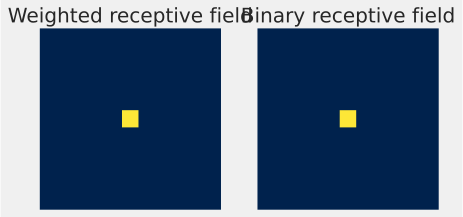

In [85]:
inp_img = torch.zeros(1, 1, 11, 11)
inp_img.requires_grad_()

def show_center_recep_field(img, out):
    """
    Calculates the gradients of the input with respect to the output center pixel,
    and visualizes the overall receptive field.
    Inputs:
        img - Input image for which we want to calculate the receptive field on.
        out - Output features/loss which is used for backpropagation, and should be
              the output of the network/computation graph.
    """
    # Determine gradients
    loss = out[0,:,img.shape[2]//2,img.shape[3]//2].sum() # L1 loss for simplicity
    loss.backward(retain_graph=True) # Retain graph as we want to stack multiple layers and show the receptive field of all of them
    img_grads = img.grad.abs()
    img.grad.fill_(0) # Reset grads

    # Plot receptive field
    img = img_grads.squeeze().cpu().numpy()
    fig, ax = plt.subplots(1,2)
    pos = ax[0].imshow(img)
    ax[1].imshow(img>0)
    # Mark the center pixel in red if it doesn't have any gradients (should be the case for standard autoregressive models)
    show_center = (img[img.shape[0]//2,img.shape[1]//2] == 0)
    if show_center:
        center_pixel = np.zeros(img.shape + (4,))
        center_pixel[center_pixel.shape[0]//2,center_pixel.shape[1]//2,:] = np.array([1.0, 0.0, 0.0, 1.0])
    for i in range(2):
        ax[i].axis('off')
        if show_center:
            ax[i].imshow(center_pixel)
    ax[0].set_title("Weighted receptive field")
    ax[1].set_title("Binary receptive field")
    plt.show()
    plt.close()

show_center_recep_field(inp_img, inp_img)

Let's first visualize the receptive field of a horizontal convolution without the center pixel. We use a small, arbitrary input image (pixels), and calculate the loss for the center pixel. For simplicity, we initialize all weights with 1 and the bias with 0, and use a single channel. This is sufficient for our visualization purposes.

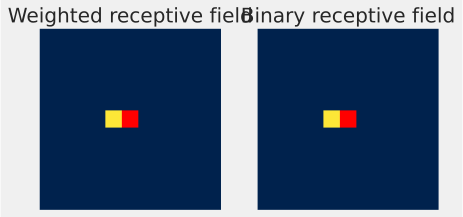

In [88]:
horiz_conv = HorizontalStackConvolution(c_in=1, c_out=1, kernel_size=3, mask_center=True)
horiz_conv.conv.weight.data.fill_(1)
horiz_conv.conv.bias.data.fill_(0)
horiz_img = horiz_conv(inp_img)
show_center_recep_field(inp_img, horiz_img)

The receptive field is shown in yellow, the center pixel in red, and all other pixels outside of the receptive field are dark blue. As expected, the receptive field of a single horizontal convolution with the center pixel masked and a
 kernel is only the pixel on the left. If we use a larger kernel size, more pixels would be taken into account on the left.

Next, let's take a look at the vertical convolution:

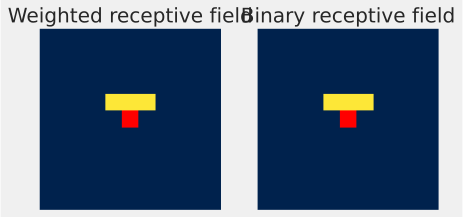

In [89]:
vert_conv = VerticalStackConvolution(c_in=1, c_out=1, kernel_size=3, mask_center=True)
vert_conv.conv.weight.data.fill_(1)
vert_conv.conv.bias.data.fill_(0)
vert_img = vert_conv(inp_img)
show_center_recep_field(inp_img, vert_img)

The vertical convolution takes all pixels above into account. Combining these two, we get the $L$-shaped receptive field of the original masked convolution:

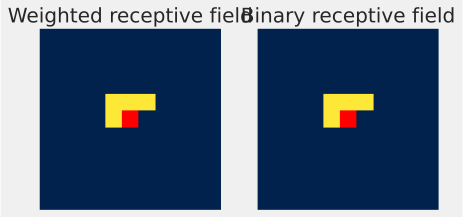

In [90]:
horiz_img = vert_img + horiz_img
show_center_recep_field(inp_img, horiz_img)

If we stack multiple horizontal and vertical convolutions, we need to take two aspects into account:

The center should not be masked anymore for the following convolutions as the features at the pixel's position are already independent of its actual value. If it is hard to imagine why we can do this, just change the value below to `mask_center=True` and see what happens.
The vertical convolution is not allowed to work on features from the horizontal convolution. In the feature map of the horizontal convolutions, a pixel contains information about all of the "true" pixels on the left. If we apply a vertical convolution which also uses features from the right, we effectively expand our receptive field to the true input which we want to prevent. Thus, the feature maps can only be merged for the horizontal convolution.
Using this, we can stack the convolutions in the following way. We have two feature streams: one for the vertical stack, and one for the horizontal stack. The horizontal convolutions can operate on the joint features of the previous horizontals and vertical convolutions, while the vertical stack only takes its own previous features as input. For a quick implementation, we can therefore sum the horizontal and vertical output features at each layer, and use those as final output features to calculate the loss on. An implementation of 4 consecutive layers is shown below. Note that we reuse the features from the other convolutions with `mask_center=True` from above.

Layer 2


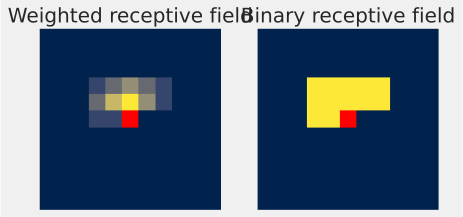

Layer 3


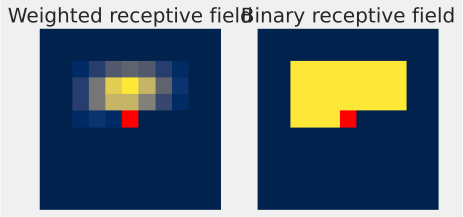

Layer 4


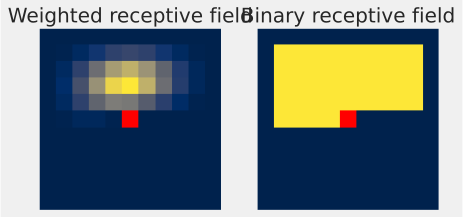

Layer 5


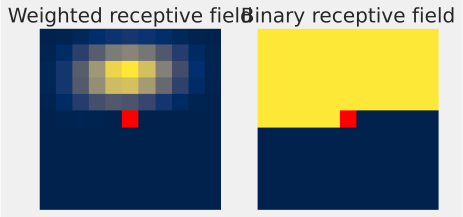

In [91]:
# Initialize convolutions with equal weight to all input pixels
horiz_conv = HorizontalStackConvolution(c_in=1, c_out=1, kernel_size=3, mask_center=False)
horiz_conv.conv.weight.data.fill_(1)
horiz_conv.conv.bias.data.fill_(0)
vert_conv = VerticalStackConvolution(c_in=1, c_out=1, kernel_size=3,mask_center=False)
vert_conv.conv.weight.data.fill_(1)
vert_conv.conv.bias.data.fill_(0)

# We reuse our convolutions for the 4 layers here. Note that in a standard network,
# we don't do that, and instead learn 4 separate convolution. As this cell is only for
# visualization purposes, we reuse the convolutions for all layers.
for l_idx in range(4):
    vert_img = vert_conv(vert_img)
    horiz_img = horiz_conv(horiz_img) + vert_img
    print(f"Layer {l_idx+2}")
    show_center_recep_field(inp_img, horiz_img)

The receptive field above it visualized for the horizontal stack, which includes the features of the vertical convolutions. It grows over layers without any blind spot as we had before. The difference between "weighted" and "binary" receptive field is that for the latter, we check whether there are any gradients flowing back to this pixel. This indicates that the center pixel indeed can use information from this pixel. Nevertheless, due to the convolution weights, some pixels have a stronger effect on the prediction than others. This is visualized in the weighted receptive field by plotting the gradient magnitude for each pixel instead of a binary yes/no.

Another receptive field we can check is the one for the vertical stack as the one above is for the horizontal stack. Let's visualize it below:

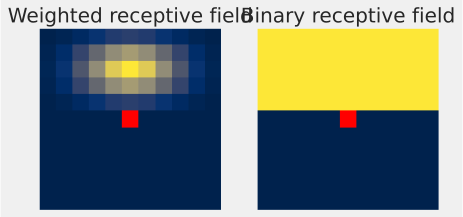

In [92]:
show_center_recep_field(inp_img, vert_img)

As we have discussed before, the vertical stack only looks at pixels above the one we want to predict. Hence, we can validate that our implementation works as we initially expected it to. As a final step, let's clean up the computation graph we still had kept in memory for the visualization of the receptive field:

In [93]:
del inp_img, horiz_conv, vert_conv

## Gated Convolutions

For visualizing the receptive field, we assumed a very simplified stack of vertical and horizontal convolutions. Obviously, there are more sophisticated ways of doing it, and PixelCNN uses gated convolutions for this. Specifically, the Gated Convolution block in PixelCNN looks as follows:

<center width="100%" style="padding: 10px"><img src="PCNN_GatedConv.svg" height="300px"></center>

The left path is the vertical stack (the $N\times N$ convolution is masked correspondingly), and the right path is the horizontal stack. Gated convolutions are implemented by having a twice as large output channel size, and combine them by a element-wise multiplication of $\tanh$ and a sigmoid. For a linear layer, we can express a gated activation unit as follows:

$$\mathbf{y} = \tanh\left(\mathbf{W}_{f}\mathbf{x}\right)\odot\sigma\left(\mathbf{W}_{g}\mathbf{x}\right)$$

For simplicity, biases have been neglected and the linear layer split into two part, $\mathbf{W}_{f}$ and $\mathbf{W}_{g}$. This concept resembles the input and modulation gate in an LSTM, and has been used in many other architectures as well. The main motivation behind this gated activation is that it might allow to model more complex interactions and simplifies learning. But as in any other architecture, this is mostly a design choice and can be considered a hyperparameters.

Besides the gated convolutions, we also see that the horizontal stack uses a residual connection while the vertical stack does not. This is because we use the output of the horizontal stack for prediction. Each convolution in the vertical stack also receives a strong gradient signal as it is only two $1\times 1$ convolutions away from the residual connection, and does not require another residual connection to all its earleri layers.

The implementation in PyTorch is fairly straight forward for this block, because the visualization above gives us a computation graph to follow:

In [94]:
class GatedMaskedConv(nn.Module):

    def __init__(self, c_in, **kwargs):
        """
        Gated Convolution block implementing the computation graph.
        """
        super().__init__()

        # Initialize vertical and horizontal stack convolutions
        self.conv_vert = VerticalStackConvolution(c_in, c_out=2*c_in, **kwargs)
        self.conv_horiz = HorizontalStackConvolution(c_in, c_out=2*c_in, **kwargs)

        # TODO: Add a 1x1 convolution to pass information from vertical stack to horizontal stack
        # Hint: Use nn.Conv2d with 2*c_in channels for both input and output
        self.conv_vert_to_horiz = nn.Conv2d(2*c_in , 2*c_in , kernel_size=1 , **kwargs )

        # TODO: Add a 1x1 convolution at the output of the horizontal stack
        # Hint: Use nn.Conv2d with c_in channels for both input and output
        self.conv_horiz_1x1 = nn.Conv2d(c_in , c_in , kernel_size=1 , **kwargs )

    def forward(self, v_stack, h_stack):
        # Vertical stack (left)
        v_stack_feat = self.conv_vert(v_stack)

        # TODO: Split the vertical stack features into value and gate using chunk
        v_value, v_gate = torch.chunk(v_stack_feat , chunks = 2, dim = 1)

        # TODO: Apply gated activation to the value and gate
        # Hint: Use torch.tanh for the value and torch.sigmoid for the gate
        v_stack_out = torch.mul(torch.tanh(v_value) , torch.sigmoid(v_gate))

        # Horizontal stack (right)
        h_stack_feat = self.conv_horiz(h_stack)

        # TODO: Add the transformed vertical stack features to the horizontal stack
        h_stack_feat2 = h_stack_feat + self.conv_vert_to_horiz(v_stack_feat)

        # TODO: Split the horizontal stack features into value and gate using chunk
        h_value, h_gate = torch.chunk(h_stack_feat2 , chunks = 2, dim = 1)

        # TODO: Apply gated activation to the value and gate
        h_activ = torch.mul(torch.tanh(h_value) , torch.sigmoid(h_gate))

        # TODO: Apply the 1x1 convolution to the horizontal stack output
        h_stack_out = self.conv_horiz_1x1(h_activ)

        # TODO: Add residual connection to the horizontal stack output
        h_stack_out = h_stack_out + h_stack

        return v_stack_out, h_stack_out

## Building the model

Using the gated convolutions, we can now build our PixelCNN model. The architecture consists of multiple stacked GatedMaskedConv blocks, where we add an additional dilation factor to a few convolutions. This is used to increase the receptive field of the model and allows to take a larger context into accout during generation. Dilation on a convolution works looks as follows:

<center width=\"100%\"><img src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/dilation.gif" width="250px"></center>

Note that the smaller output size is only because the animation assumes no padding. In our implementation, we will pad the input image correspondingly. Alternatively to dilated convolutions, we could downsample the input and use a encoder-decoder architecture as in PixelCNN++ [3]. This is especially beneficial if we want to build a very deep autoregressive model. Nonetheless, as we seek to train a reasonably small model, dilated convolutions are the more efficient option to use here.

Below, we implement the PixelCNN model as a PyTorch Lightning module. Besides the stack of gated convolutions, we also have the initial horizontal and vertical convolutions which mask the center pixel, and a final $1\times 1$ convolution which maps the output features to class predictions. To determine the likelihood of a batch of images, we first create our initial features using the masked horizontal and vertical input convolution. Next, we forward the features through the stack of gated convolutions. Finally, we take the output features of the horizontal stack, and apply the $1\times 1$ convolution for classification. We use the bits per dimension metric for the likelihood.

In [95]:
class PixelCNN(pl.LightningModule):

    def __init__(self, c_in, c_hidden):
        super().__init__()
        self.save_hyperparameters()

        # Initial convolutions skipping the center pixel
        # TODO: Initialize vertical stack convolution
        # TODO: Initialize horizontal stack convolution
        self.conv_vstack = VerticalStackConvolution(c_in, c_out=c_hidden, mask_center=True)
        self.conv_hstack = HorizontalStackConvolution(c_in, c_out=c_hidden,  mask_center=True)

        # TODO: Create a list of GatedMaskedConv layers with different dilations.
        # Hint: Use nn.ModuleList to store the layers
        self.conv_layers = nn.ModuleList( [
            GatedMaskedConv(c_hidden),
            GatedMaskedConv(c_hidden , dilation = 2 ),
            GatedMaskedConv(c_hidden),
            GatedMaskedConv(c_hidden , dilation = 4 ),
            GatedMaskedConv(c_hidden),
            GatedMaskedConv(c_hidden , dilation = 2 ),
            GatedMaskedConv(c_hidden),
            ] )
        # Output classification convolution (1x1)
        self.conv_out = nn.Conv2d(c_hidden, c_in * 256, kernel_size=1, padding=0)

        self.example_input_array = train_set[0][0][None]  # Optional, for showing an example input in PyTorch Lightning

    def forward(self, x):
        """
        Forward image through model and return logits for each pixel.
        Inputs:
            x - Image tensor with integer values between 0 and 255.
        """
        # TODO: Scale input from 0-255 to -1 to 1
        x = (x.float() / 255.0) * 2 - 1

        # TODO: Apply the initial vertical and horizontal stack convolutions to x
        stack_v = self.conv_vstack(x)
        stack_h = self.conv_hstack(x)

        # Gated Convolutions
        for layer in self.conv_layers:
            # TODO: Pass the vertical and horizontal stacks through each layer
            stack_v , stack_h = layer(stack_v , stack_h)


        # TODO: Apply ELU activation and 1x1 convolution to the horizontal stack output
        out = F.elu(stack_h)
        out = self.conv_out(out)

        # TODO: Reshape the output to match the pixel classification problem, Output dimensions: [Batch, Classes, Channels, Height, Width]
        return out.view(out.shape[0], 256, out.shape[1]//256, out.shape[2], out.shape[3])

    def calc_likelihood(self, x):
        # TODO: Implement the forward pass and calculate the negative log-likelihood
        # Hint: Use F.cross_entropy to compute the loss and return bpd
        logits = self.forward(x)
        loss = F.cross_entropy(logits, x, reduction='none')
        bpd = loss.mean(dim=[1,2,3]) * np.log2(np.exp(1))
        return bpd.mean()

    @torch.no_grad()
    def sample(self, img_shape, img=None):
        """
        Sampling function for the autoregressive model.
        Inputs:
            img_shape - Shape of the image to generate (B,C,H,W)
            img (optional) - If given, this tensor will be used as
                             a starting image. The pixels to fill
                             should be -1 in the input tensor.
        """
        # TODO: Initialize the image with zeros if img is None
        if img is None:
           img = torch.zeros(img_shape).to(device) - 1

        # Generation loop
        for h in tqdm(range(img_shape[2]), leave=False):
            for w in range(img_shape[3]):
                for c in range(img_shape[1]):
                    # TODO: Skip already filled pixels
                    if (img[:,c,h,w] != -1).all():
                        continue  # Skip already filled pixels
                    logits = self.forward(img[:,:,:h+1,:])
                    probs = F.softmax(logits[:, :, c, h, w], dim=-1)
                    pixel_val = torch.multinomial(probs, num_samples=1).squeeze(dim=-1)
                    img[:, c, h, w] = pixel_val

        return img

    def configure_optimizers(self):
        # TODO: Create an Adam optimizer and StepLR scheduler
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # TODO: Calculate the loss and log it during training
        x, _ = batch
        loss = self.calc_likelihood(x)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        # TODO: Calculate the loss and log it during validation
        x, _ = batch
        loss = self.calc_likelihood(x)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx, dataloader_idx=0):
        # TODO: Calculate the loss and log it during testing
        x, _ = batch
        loss = self.calc_likelihood(x)
        self.log('test_loss', loss)

To sample from the autoregressive model, we need to iterate over all dimensions of the input. We start with an empty image, and fill the pixels one by one, starting from the upper left corner. Note that as for predicting $x_i$, all pixels below it have no influence on the prediction. Hence, we can cut the image in height without changing the prediction while increasing efficiency. Nevertheless, all the loops in the sampling function already show that it will take us quite some time to sample. A lot of computation could be reused across loop iterations as those the features on the already predicted pixels will not change over iterations. Nevertheless, this takes quite some effort to implement, and is often not done in implementations because in the end, autoregressive sampling remains sequential and slow. Hence, we settle with the default implementation here.

Before training the model, we can check the full receptive field of the model on an MNIST image of size $28\times 28$:

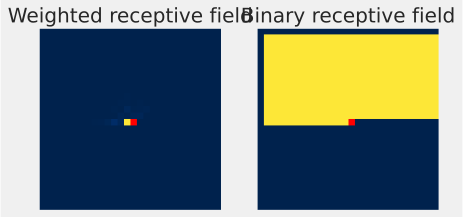

In [96]:
test_model = PixelCNN(c_in=1, c_hidden=64)
inp = torch.zeros(1,1,28,28)
inp.requires_grad_()
out = test_model(inp)
show_center_recep_field(inp, out.squeeze(dim=2))
del inp, out, test_model

The visualization shows that for predicting any pixel, we can take almost half of the image into account. However, keep in mind that this is the "theoretical" receptive field and not necessarily the effective receptive field, which is usually much smaller. For a stronger model, we should therefore try to increase the receptive field even further. Especially, for the pixel on the bottom right, the very last pixel, we would be allowed to take into account the whole image. However, our current receptive field only spans across 1/4 of the image. An encoder-decoder architecture can help with this, but it also shows that we require a much deeper, more complex network in autoregressive models than in VAEs or energy-based models.

## Training loop
To train the model, we again can rely on PyTorch Lightning and write a function below for loading the pretrained model if it exists. **In this section, you may not be able to train the model more than 20 or 30 epochs, as you are using Google Colab or kaggle probably. Consequently, we have saved the pre-trained (with 150 epochs) model for you to use it and write and validate other details of your code (e.g. visualizations, sampling, autocompletions, ...) except building the model and training procedure. Then, just derive your own model (by completing corresponding preious and further sections) and run it to reach some acceptable results. The saved model in "PixelCNN.ckpt"** Moreover, To reduce the computational cost, we have saved the validation and test score in the checkpoint already:

In [97]:
def train_model(**kwargs):
    # TODO: Create a PyTorch Lightning trainer with the necessary settings
    trainer = pl.Trainer(default_root_dir=os.path.join('../saved_model', "PixelCNN"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=15,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_bpd"),
                                    LearningRateMonitor("epoch")])
    # Hint: Set the correct device (GPU/CPU) and define callbacks like ModelCheckpoint and LearningRateMonitor

    result = None

    # Path to the pre-trained checkpoint (for example on Kaggle)
    pretrained_filename = '/content/PixelCNN.ckpt'  # TODO: Set the correct path for the pre-trained model

    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        # TODO: Load the pre-trained model from checkpoint using PixelCNN
        model = PixelCNN.load_from_checkpoint(pretrained_filename, **kwargs)
        ckpt = torch.load(pretrained_filename, map_location=device)
        result = ckpt.get("result", None)
    else:
        print("Pretrained model not found")
        # Initialize PixelCNN with the provided arguments (kwargs)
        model = PixelCNN(**kwargs)
        # TODO: Train the model using trainer.fit and provide the training and validation loaders
        trainer.fit(model, train_loader, val_loader)

    # TODO: Move the model to the correct device (CPU or GPU)
    model.to(device)

    if result is None:
        # TODO: Test the best model on the validation and test sets using trainer.test
        # Hint: Use the validation and test loaders, and store the results in 'result'
        #result = trainer.test(model, dataloaders=[val_loader, test_loader])
        val_result = trainer.test(model, val_loader, verbose=False)
        test_result = trainer.test(model, test_loader, verbose=False)
        result = {"test": test_result, "val": val_result}

    return model, result


In [99]:
model, result = train_model(c_in=1, c_hidden=64)
test_res = result["test"][0]
print("Test bits per dimension: %4.3fbpd" % (test_res["test_loss"] if "test_loss" in test_res else test_res["test_bpd"]))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v0.9.0 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint PixelCNN.ckpt`


Found pretrained model, loading...
Test bits per dimension: 0.808bpd


<ipython-input-97-cc3418061c08>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(pretrained_filename, map_location=device)


Now, answer the **Question:**

Why considering image modeling as an autoregressive problem simplifies the learning process?

Explain your **Answer:**

Considering image modeling as an autoregressive problem simplifies the learning process by breaking down the complex task of generating an image into a sequential process, where each pixel is predicted based on previously generated ones.

In addition, PixelCNN can explicitly predict the pixel values by a discrete softmax while Normalizing Flows (which you will learn further) have to learn transformations in continuous latent space. These two aspects allow the PixelCNN to achieve a notably better performance.

To fully compare the models, let's also measure the number of parameters of the PixelCNN:

In [100]:
num_params = sum([np.prod(param.shape) for param in model.parameters()])
print("Number of parameters: {:,}".format(num_params))

Number of parameters: 852,160


Compared to the multi-scale normalizing flows, the PixelCNN has considerably less parameters. Of course, the number of parameters depend on our hyperparameter choices. Nevertheless, in general, it can be said that autoregressive models require considerably less parameters than normalizing flows to reach good performance, based on the reasons stated above. Still, autoregressive models are much slower in sampling than normalizing flows, which limits their possible applications.

## Sampling
One way of qualitatively analysing generative models is by looking at the actual samples. Let's therefore use our sampling function to generate a few digits:

INFO:lightning_fabric.utilities.seed:Seed set to 4


  0%|          | 0/28 [00:00<?, ?it/s]

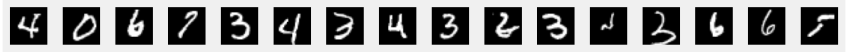

In [101]:
# TODO: Ensure the model is moved to the correct device (GPU or CPU)

# TODO: Set a random seed using pl.seed_everything() for reproducibility
pl.seed_everything(4)

# TODO: Generate samples using the model's sample function with the correct image shape
# Hint: Make sure to move the generated samples to the same device as the model
samples = model.sample(img_shape=(16,1,28,28))

# TODO: Display the generated samples using show_imgs()
# Hint: Move samples back to the CPU if needed for visualization
show_imgs(samples.cpu())

Most of the samples should be identified as digits. This goes along with the lower likelihood we achieved with autoregressive models. Nevertheless, we also see that there is still place for improvement as a considerable amount of samples cannot be identified. Deeper autoregressive models are expected to achieve better quality, as they can take more context into account for generating the pixels.

Note that on Google Colab or Kaggle, you might see different results, specifically with a white line at the top. After some debugging, it seemed that the difference occurs inside the dilated convolution, as it gives different results for different batch sizes. However, it is hard to debug this further as it might be a bug of the installed PyTorch version on them.

The trained model itself is not restricted to any specific image size. However, what happens if we actually sample a larger image than we had seen in our training dataset? Let's try below to sample images of size $64\times 64$ instead of $28\times 28$:

INFO:lightning_fabric.utilities.seed:Seed set to 4


  0%|          | 0/64 [00:00<?, ?it/s]

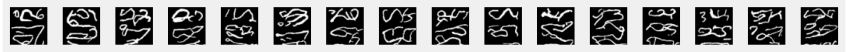

In [102]:
# TODO: Fill it like previous cell

# TODO: Ensure the model is moved to the correct device (GPU or CPU)

# TODO: Set a random seed using pl.seed_everything() for reproducibility
pl.seed_everything(4)

# TODO: Generate samples using the model's sample function with the correct image shape
# Hint: Make sure to move the generated samples to the same device as the model
samples = model.sample(img_shape=(16,1,64,64))

# TODO: Display the generated samples using show_imgs()
# Hint: Move samples back to the CPU if needed for visualization
show_imgs(samples.cpu())

Now, answer the **Question:**

What do you see in the results? Why do you think it is like that? Justify your answer.

Explain your **Answer:**

The reason for these weird shapres that don't resemble numbers at all, is that our model only learnes the distribution of numbers across a 28*28 grid. sampling it on a bigger grid means that model can't fully see what it has drawn or how the different heights and widths of the grid affect its mapped distribution.   

## Autocompletion
One common application done with autoregressive models is auto-completing an image. As autoregressive models predict pixels one by one, we can set the first $N$ pixels to predefined values and check how the model completes the image. For implementing this, we just need to skip the iterations in the sampling loop that already have a value unequals -1. In the cell below, we randomly take three images from the training set, mask about the lower half of the image, and let the model autocomplete it. To see the diversity of samples, we do this 12 times for each image:

Original image and input image to sampling:


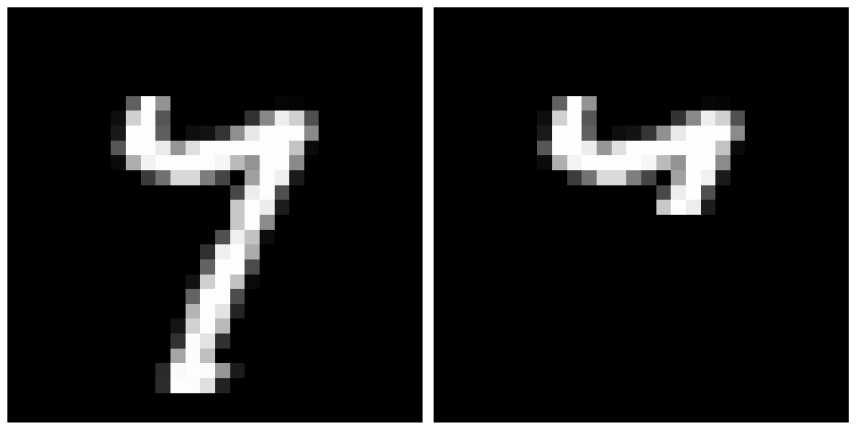

INFO:lightning_fabric.utilities.seed:Seed set to 2


  0%|          | 0/28 [00:00<?, ?it/s]

Autocompletion samples:


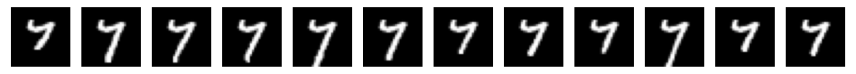

Original image and input image to sampling:


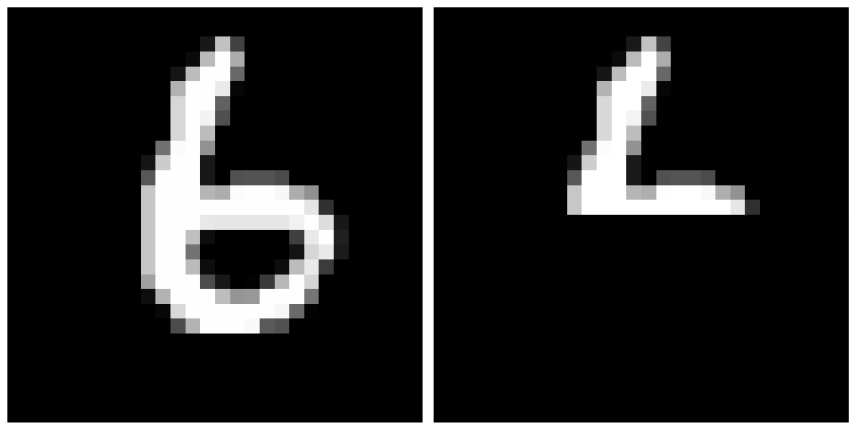

INFO:lightning_fabric.utilities.seed:Seed set to 2


  0%|          | 0/28 [00:00<?, ?it/s]

Autocompletion samples:


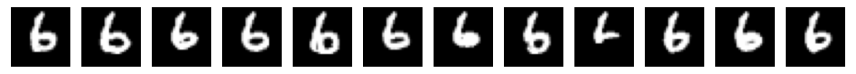

Original image and input image to sampling:


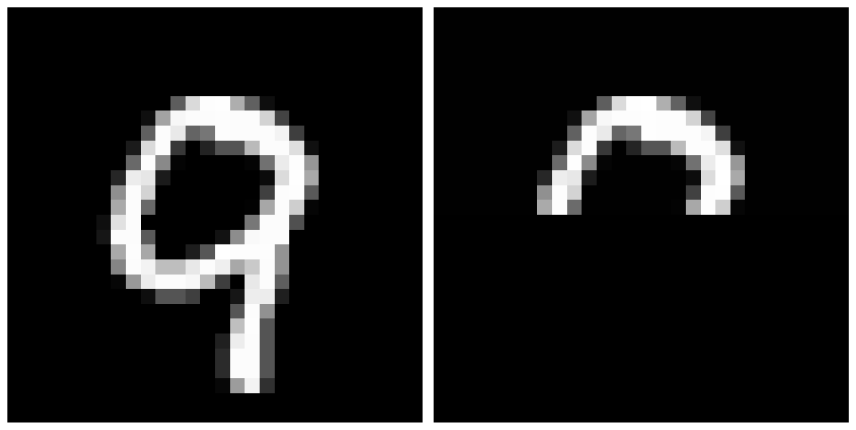

INFO:lightning_fabric.utilities.seed:Seed set to 2


  0%|          | 0/28 [00:00<?, ?it/s]

Autocompletion samples:


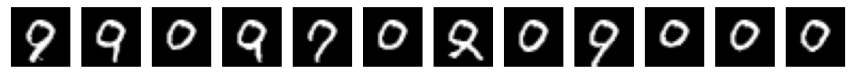

In [ ]:
def autocomplete_image(img):
    # TODO: Create a copy of the image (img.clone()) and set the lower half of the image to -1
    image = img.clone()
    image[:, img.shape[2]//2: , :] = -1

    print("Original image and input image to sampling:")
    # TODO: Display the original and modified input images using show_imgs
    show_imgs([img , image])

    # TODO: Generate 12 copies of the incomplete image for sampling using img_init.unsqueeze and repeat
    # Hint: Ensure the images are moved to the correct device
    image = image.unsqueeze(0)
    c_images = torch.zeros([12 , img.shape[0] , img.shape[1] , img.shape[2] ])

    for i in range(12):
      c_images[i,:,:,:] = image

    c_images.to(device)
    # TODO: Set a random seed for reproducibility before sampling
    pl.seed_everything(2)

    # TODO: Generate image completions using the model's sample function
    img_generated = model.sample(c_images.shape , c_images)

    print("Autocompletion samples:")
    show_imgs(img_generated)

# Autocomplete images from the dataset (train_set)
for i in range(1, 4):
    img = train_set[i][0]
    autocomplete_image(img.to(device))


Now, answer the **Question:**

What do you see in the results? Why do you think it is like that? Justify your answer.

Explain your **Answer:**

We see that in most cases the images are correctly reconstructed to resemble actual numbers. This is because by giving some prior knowledge about the potential shape of the number the model can better understand and predict the following pixels.

## References

[1] van den Oord, A., et al. "Pixel Recurrent Neural Networks." arXiv preprint arXiv:1601.06759 (2016).

[2] van den Oord, A., et al. "Conditional Image Generation with PixelCNN Decoders." In Advances in Neural Information Processing Systems 29, pp. 4790–4798 (2016).

[3] Salimans, Tim, et al. "PixelCNN++: Improving the PixelCNN with Discretized Logistic Mixture Likelihood and Other Modifications." arXiv preprint arXiv:1701.05517 (2017).